#### **Step 1: -** Connecting it to Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/YOLOv8'
!pwd

/content/drive/My Drive/YOLOv8
/content/drive/My Drive/YOLOv8


#### **Step 2: -** Installing required libraries

In [3]:
!pip install seaborn
!pip install scikit-learn
!pip install opencv-python
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.4/756.4 kB 19.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

#### **Step 3: -** Loading the required libraries for object detection

In [4]:
# Libraries for loading the images
import os
import cv2
from PIL import Image

# Libraries for viewing the images and results
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Libraries for pre-processing the images
import numpy as np
import shutil

# Libraries for data analysis
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Libraries for building and evaluting the models
from ultralytics import YOLO
from IPython.display import Image, display

#### **Step 4: -** loading the Basil Crop Images and Annoations

In [5]:
# Setting the input images and annotations folder paths
input_images_folder = "datasets/Basil Crop/images/"
input_labels_folder = "datasets/Basil Crop/labels/"

In [6]:
# Function to read bounding box annotations from a text file
def read_annotations(annotation_file_path):
    annotations = []
    with open(annotation_file_path, 'r') as file:
        for line in file:
            line = line.strip().split()
            if len(line) == 4:
                x_min, y_min, x_max, y_max = map(float, line)
                annotations.append((x_min, y_min, x_max, y_max))
    return annotations

In [7]:
def load_images_with_annotations():
    # Creating a list to store the images and annotations paths
    imgs = []

    # Loading the paths for input images and annotations
    for filename in os.listdir(os.path.join(input_images_folder)):
        if filename.endswith('.jpg'):
            img_path = os.path.join(output_images_folder, filename)
            annotation_path = os.path.join(output_labels_folder, filename.replace('.jpg', '.txt'))
            imgs.append((img_path, annotation_path))
    return imgs

#### **Step 5: -** Images and Annotations pre-processing

##### i) Resizing the images and labels

In [8]:
# Setting the prefered image size for YOLOv8 (640 X 480)
target_width = 640
target_height = 480

In [9]:
# Creating the output folders to store the resized images and labels
output_images_folder = "datasets/Basil Crop/resized_images/"
output_labels_folder = "datasets/Basil Crop/resized_labels/"

os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

In [10]:
image_files = os.listdir(input_images_folder)

for image_file in image_files:
    image_path = os.path.join(input_images_folder, image_file)
    image = cv2.imread(image_path)
    if image is not None:
        # Resizing the image
        resized_image = cv2.resize(image, (target_width, target_height))

        # Saving the resized image
        output_image_path = os.path.join(output_images_folder, image_file)
        cv2.imwrite(output_image_path, resized_image)

        # Processing the corresponding annotation file
        annotation_file = os.path.splitext(image_file)[0] + ".txt"
        annotation_path = os.path.join(input_labels_folder, annotation_file)

        if os.path.exists(annotation_path):
            # Reading the annotation file line by line
            with open(annotation_path, 'r') as file:
                lines = file.readlines()

            # Processing and updating the bounding boxes
            with open(os.path.join(output_labels_folder, annotation_file), 'w') as output_annotation_file:
                updated_lines = []  # To store updated annotation lines
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 4:  # Checking if the line has exactly 4 elements
                        x_min, y_min, x_max, y_max = map(float, parts)

                        # Resizing the bounding box coordinates
                        x_min *= target_width / image.shape[1]
                        y_min *= target_height / image.shape[0]
                        x_max *= target_width / image.shape[1]
                        y_max *= target_height / image.shape[0]

                        # Updating the line with resized coordinates
                        updated_line = f"{x_min} {y_min} {x_max} {y_max}"

                        updated_lines.append(updated_line)

                # Writing the updated lines to the output annotation file
                for updated_line in updated_lines:
                    output_annotation_file.write(updated_line + '\n')

##### ii) Viewing the loaded and resized images with annoations

In [11]:
# Function to display a grid of images with bounding boxes
def display_image_grid(images, rows, cols, grid_title):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    for i, ax in enumerate(axes.ravel()):
        if i < len(images):
            img_path, annotation_path = images[i]
            image = cv2.imread(img_path)
            annotations = read_annotations(annotation_path)
            for annotation in annotations:
                x_min, y_min, x_max, y_max = map(int, annotation)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            ax.axis('off')

    plt.suptitle(grid_title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
# loading and resizing the images and annoations
images = load_images_with_annotations()

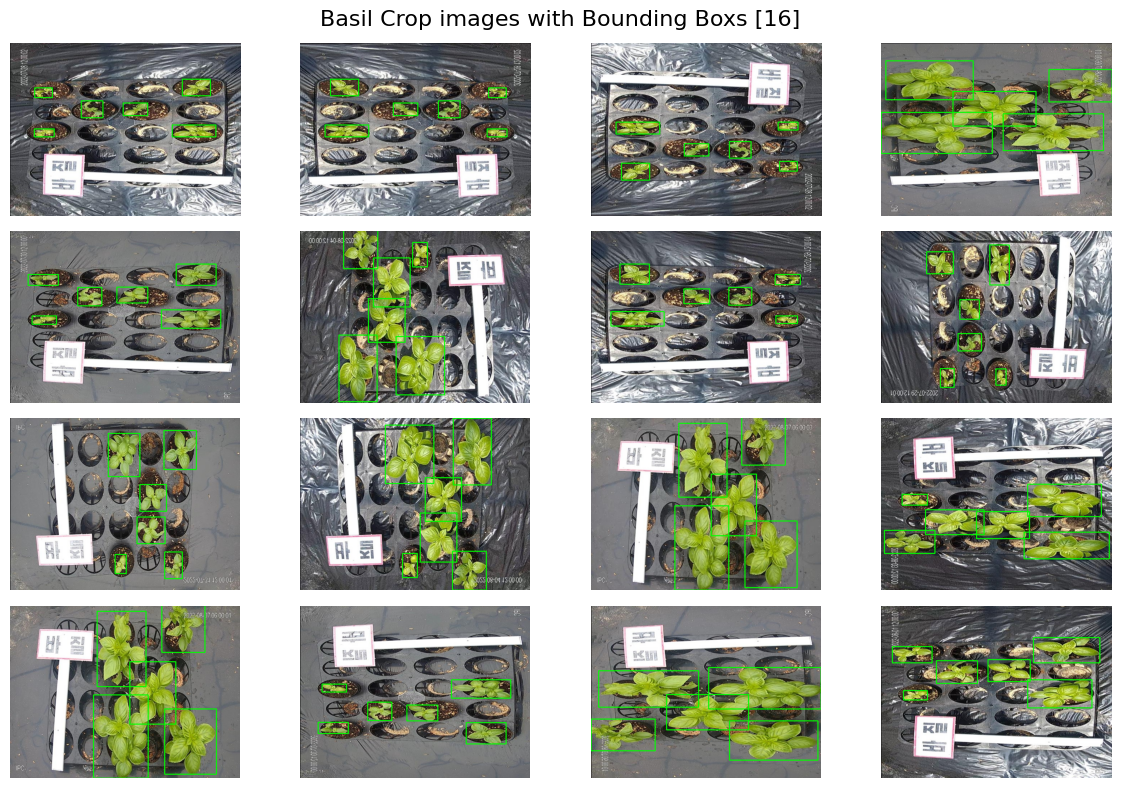

In [13]:
# Displaying a grid of images with bounding boxes (4x4 grid)
display_image_grid(images, rows=4, cols=4, grid_title="Basil Crop images with Bounding Boxs [16]")

##### iii) Normalizing the labels

In [14]:
# Specifing the input and output labels folders
input_labels_folder = "datasets/Basil Crop/resized_labels/"
output_normalized_labels_folder = "datasets/Basil Crop//normalized_labels/"

os.makedirs(output_normalized_labels_folder, exist_ok=True)

In [15]:
# List all annotation files in the input folder
annotation_files = os.listdir(input_labels_folder)

for annotation_file in annotation_files:
    annotation_path = os.path.join(input_labels_folder, annotation_file)

    # Reading the normalized bounding box annotations
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    # Create an output YOLOv8 annotation file
    output_yolov8_file = os.path.join(output_normalized_labels_folder, annotation_file)

    with open(output_yolov8_file, 'w') as output_file:
        for i, line in enumerate(lines):
            parts = line.strip().split()
            if len(parts) == 4:
                x_min, y_min, x_max, y_max = map(float, parts)

                # Normalize x and y coordinates
                x_min_normalized = x_min / target_width
                y_min_normalized = y_min / target_height
                x_max_normalized = x_max / target_width
                y_max_normalized = y_max / target_height

                # Calculating YOLOv8 format values
                x_center = (x_min_normalized + x_max_normalized) / 2.0
                y_center = (y_min_normalized + y_max_normalized) / 2.0
                width = x_max_normalized - x_min_normalized
                height = y_max_normalized - y_min_normalized

                # Converting to YOLOv8 format and write to the output file
                yolo_line = f"0 {x_center} {y_center} {width} {height}\n"
                output_file.write(yolo_line)

##### iv) Splitting the images into Train and Val Datasets

In [16]:
# Specifying the source folder containing all images and annotations
source_folder_images = "datasets/Basil Crop/resized_images/"
source_folder_labels = "datasets/Basil Crop/normalized_labels/"

In [17]:
# Specifying the destination folder where the "train" and "val" folders will be created
destination_folder = "datasets/"

In [18]:
# Create the "train" and "val" folders
train_folder = os.path.join(destination_folder, "train")
val_folder = os.path.join(destination_folder, "val")

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

In [19]:
# Creating "images" and "labels" subfolders inside "train" and "val"
train_images_folder = os.path.join(train_folder, "images")
train_labels_folder = os.path.join(train_folder, "labels")
val_images_folder = os.path.join(val_folder, "images")
val_labels_folder = os.path.join(val_folder, "labels")

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)

In [20]:
# Listing all image and annotation files
image_files = sorted(os.listdir(os.path.join(source_folder_images)))
annotation_files = sorted(os.listdir(os.path.join(source_folder_labels)))

In [21]:
# Splitting the dataset into "train" and "val"
train_image_files = image_files[:171]
train_annotation_files = annotation_files[:171]
val_image_files = image_files[171:]
val_annotation_files = annotation_files[171:]

In [22]:
# Copy "train" images and annotations to the corresponding folders
for image_file, annotation_file in zip(train_image_files, train_annotation_files):
    source_image_path = os.path.join(source_folder_images, image_file)
    source_annotation_path = os.path.join(source_folder_labels, annotation_file)
    destination_image_path = os.path.join(train_images_folder, image_file)
    destination_annotation_path = os.path.join(train_labels_folder, annotation_file)

    shutil.copy(source_image_path, destination_image_path)
    shutil.copy(source_annotation_path, destination_annotation_path)

In [23]:
# Copy "val" images and annotations to the corresponding folders
for image_file, annotation_file in zip(val_image_files, val_annotation_files):
    source_image_path = os.path.join(source_folder_images, image_file)
    source_annotation_path = os.path.join(source_folder_labels, annotation_file)
    destination_image_path = os.path.join(val_images_folder, image_file)
    destination_annotation_path = os.path.join(val_labels_folder, annotation_file)

    shutil.copy(source_image_path, destination_image_path)
    shutil.copy(source_annotation_path, destination_annotation_path)

#### **Step 6: -** Building the model

In [24]:
# Downloading and loading the Yolov8 model
model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 167MB/s]


#### **Step 7: -** Training the model

In [25]:
# Training the model with Basil crop dataset
model.train(data="Basil.yaml", epochs=100, batch=19)

Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=Basil.yaml, epochs=100, time=None, patience=100, batch=19, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 112MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/YOLOv8/datasets/train/labels... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:01<00:00, 104.71it/s]


train: New cache created: /content/drive/MyDrive/YOLOv8/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/YOLOv8/datasets/val/labels... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 48.29it/s]


val: New cache created: /content/drive/MyDrive/YOLOv8/datasets/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00044531249999999996), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.95G       1.24      2.698      1.463        198        640: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

                   all         38        187     0.0164          1      0.877      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.51G     0.6971      1.238      1.027        163        640: 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         38        187      0.964      0.989      0.979      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.51G     0.5934     0.6974     0.9647        221        640: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         38        187      0.977      0.694      0.888       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.63G     0.5338     0.6158     0.9368        205        640: 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         38        187      0.913      0.955      0.968      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.63G     0.5309        0.6     0.9411        177        640: 100%|██████████| 9/9 [00:04<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         38        187      0.963      0.984      0.973      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.51G     0.5779     0.6188     0.9564        204        640: 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         38        187      0.965      0.973      0.982       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.51G      0.538     0.5639     0.9392        189        640: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         38        187      0.959      0.984      0.982      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.51G     0.5441     0.5699     0.9436        189        640: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         38        187      0.958      0.965      0.976      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.51G     0.5524     0.5273      0.936        200        640: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         38        187       0.98      0.995      0.982      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.51G     0.5768     0.5438     0.9505        189        640: 100%|██████████| 9/9 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         38        187      0.953      0.984      0.983      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.51G     0.5405     0.5121     0.9277        197        640: 100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         38        187      0.939          1      0.983      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.51G     0.5281     0.5122     0.9421        179        640: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         38        187      0.897      0.977      0.961      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.51G     0.5102     0.4892     0.9216        203        640: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         38        187      0.981      0.973       0.98       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.51G     0.5101     0.4723     0.9199        194        640: 100%|██████████| 9/9 [00:02<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         38        187      0.974          1      0.981      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.52G     0.5105     0.4762     0.9202        182        640: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         38        187      0.979      0.998      0.983      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.51G     0.4951     0.4627     0.9143        158        640: 100%|██████████| 9/9 [00:04<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         38        187      0.979          1      0.982      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.51G     0.4835     0.4414     0.9082        207        640: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         38        187      0.974      0.979      0.979      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.51G     0.4859     0.4351     0.9194        185        640: 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         38        187      0.927      0.957      0.961      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.51G     0.4812     0.4216     0.9053        197        640: 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         38        187      0.953      0.989      0.977      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.63G     0.4992     0.4317      0.912        173        640: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         38        187      0.984      0.998      0.987      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.6G     0.4736     0.4267     0.9014        208        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         38        187      0.959      0.995      0.979      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.64G     0.4646     0.4065     0.9063        162        640: 100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         38        187      0.961          1      0.975      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.51G     0.4348     0.3828     0.8948        188        640: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         38        187      0.972          1       0.98      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.6G     0.4642     0.3878     0.9032        181        640: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         38        187      0.984          1      0.982      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.51G     0.4533     0.3793     0.8851        201        640: 100%|██████████| 9/9 [00:04<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         38        187      0.979          1      0.982      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.63G     0.4734     0.3818     0.8988        197        640: 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         38        187      0.983          1      0.982      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.51G     0.4507     0.3758     0.9002        187        640: 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         38        187      0.982          1      0.981      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.51G     0.4292     0.3623       0.89        141        640: 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         38        187      0.983          1       0.98       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.51G     0.4643     0.3647      0.892        213        640: 100%|██████████| 9/9 [00:04<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         38        187      0.982          1       0.98      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.63G     0.4406     0.3554     0.8968        197        640: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         38        187      0.983          1      0.988      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.51G     0.4362     0.3501     0.8973        161        640: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         38        187      0.978          1      0.984      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.63G     0.4341     0.3538     0.8909        178        640: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         38        187       0.97          1      0.983      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.51G     0.4399     0.3575     0.9068        169        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         38        187      0.979      0.994      0.985      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.63G     0.4209     0.3457     0.8853        157        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         38        187      0.977          1      0.984      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.51G     0.4354     0.3462     0.8924        218        640: 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         38        187      0.982          1       0.98      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.51G      0.422     0.3423     0.8814        154        640: 100%|██████████| 9/9 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         38        187      0.982          1      0.984      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.51G      0.414     0.3311     0.8721        181        640: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         38        187      0.978          1      0.983      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.63G     0.4324     0.3356     0.8874        201        640: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         38        187      0.984          1      0.986      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.51G     0.4161       0.32     0.8794        180        640: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         38        187      0.983          1      0.988       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.51G     0.4082     0.3119     0.8768        202        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         38        187      0.984          1      0.989      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.63G     0.4177     0.3255     0.8873        171        640: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         38        187      0.982          1      0.986      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.51G     0.4156     0.3145     0.8832        192        640: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         38        187      0.983          1      0.986       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.51G     0.4005     0.3154     0.8718        215        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         38        187      0.979          1      0.992      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.51G     0.4202     0.3128     0.8869        184        640: 100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         38        187      0.979       0.99      0.985      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.6G      0.383     0.3111     0.8745        212        640: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         38        187      0.984          1      0.981      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.51G     0.3985     0.3101     0.8803        178        640: 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         38        187      0.984          1      0.983      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.52G     0.3893     0.3056     0.8743        186        640: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         38        187      0.983          1      0.989      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.51G     0.3843     0.2992     0.8646        174        640: 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         38        187      0.984          1      0.993      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.51G     0.3851     0.2928     0.8694        181        640: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         38        187      0.983          1      0.992      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.51G     0.3917     0.2936     0.8727        147        640: 100%|██████████| 9/9 [00:04<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         38        187      0.982          1      0.986      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.63G     0.3712     0.2796     0.8672        163        640: 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         38        187      0.981          1      0.986      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.51G     0.3736     0.2832     0.8653        211        640: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         38        187      0.974          1      0.987      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.63G      0.358     0.2817     0.8712        167        640: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         38        187      0.984          1       0.98      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.5G     0.3793     0.2806     0.8624        180        640: 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         38        187      0.984          1      0.982      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.51G     0.3784      0.282     0.8684        192        640: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         38        187      0.983          1      0.985      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.51G     0.3647     0.2757       0.86        191        640: 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         38        187      0.978          1      0.986       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.51G      0.367     0.2748     0.8665        193        640: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         38        187      0.978          1      0.979      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.51G      0.361     0.2777     0.8625        193        640: 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         38        187      0.983          1      0.983      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.51G     0.3663     0.2688     0.8696        186        640: 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         38        187      0.984          1      0.989      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.51G     0.3741      0.279     0.8743        200        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         38        187      0.978          1      0.992      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.51G     0.3579     0.2621     0.8676        184        640: 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         38        187      0.984      0.999      0.993      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.51G     0.3581     0.2711     0.8636        176        640: 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         38        187      0.974      0.998      0.989      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.63G     0.3587     0.2642     0.8622        167        640: 100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         38        187      0.978          1      0.986      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.52G     0.3654      0.268     0.8663        196        640: 100%|██████████| 9/9 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         38        187      0.973          1      0.986      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.51G     0.3485     0.2605     0.8639        170        640: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         38        187      0.976          1      0.987      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.51G     0.3464     0.2559     0.8597        186        640: 100%|██████████| 9/9 [00:04<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         38        187      0.979      0.991      0.989      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.51G     0.3409     0.2544     0.8623        160        640: 100%|██████████| 9/9 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         38        187      0.979      0.989      0.989       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.63G     0.3418     0.2581     0.8682        167        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         38        187      0.984      0.995      0.987       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.51G     0.3456     0.2538     0.8606        169        640: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         38        187      0.979          1       0.98      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.51G     0.3467     0.2501     0.8576        184        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         38        187      0.979          1       0.98       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.64G     0.3447      0.251     0.8544        175        640: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         38        187      0.979      0.998      0.984      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.51G     0.3575     0.2566     0.8659        186        640: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         38        187      0.977          1      0.991      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.63G     0.3447     0.2537     0.8607        188        640: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         38        187      0.983          1      0.987      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.64G     0.3365     0.2497      0.854        209        640: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         38        187      0.983          1      0.986      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.6G     0.3431      0.252     0.8638        178        640: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         38        187      0.983          1      0.984      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.5G     0.3435     0.2542     0.8632        166        640: 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         38        187      0.984          1      0.984      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.51G     0.3404     0.2443      0.858        207        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         38        187      0.984          1      0.984       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.51G     0.3407     0.2505     0.8627        190        640: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         38        187      0.984          1      0.982      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.63G     0.3425     0.2438     0.8621        217        640: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         38        187      0.984          1      0.981       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.51G     0.3282      0.236     0.8516        179        640: 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         38        187      0.984          1      0.981      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.51G     0.3365     0.2417     0.8508        151        640: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         38        187      0.984          1      0.983       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.51G     0.3269     0.2326      0.848        206        640: 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         38        187      0.984          1      0.983       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.51G     0.3254     0.2355     0.8526        202        640: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         38        187      0.984          1      0.984      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.51G     0.3304     0.2351       0.85        169        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         38        187      0.979          1      0.986      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.51G     0.3295     0.2367     0.8513        186        640: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         38        187      0.974          1      0.985      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.5G     0.3255     0.2318     0.8539        176        640: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         38        187      0.974          1      0.985      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.51G     0.3188     0.2239     0.8414        172        640: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         38        187      0.984          1      0.986      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.63G      0.313     0.2289     0.8501        198        640: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         38        187      0.973          1      0.986      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.51G     0.3205     0.2341     0.8552        195        640: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         38        187      0.979          1      0.987      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.51G     0.3177     0.2199     0.8513        196        640: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         38        187      0.984          1       0.99      0.938


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.9G     0.2644     0.2049     0.8138         97        640: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         38        187      0.984          1      0.989      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.58G     0.2573     0.1947      0.812         96        640: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         38        187      0.984          1      0.984      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.58G     0.2559     0.1946     0.8041         96        640: 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         38        187      0.984          1      0.982      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.58G     0.2462     0.1834     0.8023         97        640: 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         38        187      0.982          1       0.98      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.58G     0.2489     0.1834     0.7999         97        640: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         38        187      0.982          1       0.98      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.58G     0.2485     0.1809     0.8084         96        640: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         38        187      0.983          1       0.98      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.58G     0.2475     0.1821     0.8032         98        640: 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         38        187      0.984          1       0.98      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.58G     0.2484     0.1774     0.7944         97        640: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         38        187      0.984          1       0.98      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.58G     0.2497     0.1809     0.8032         94        640: 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         38        187      0.984          1      0.981      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.58G     0.2447     0.1774     0.8002         97        640: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         38        187      0.984          1      0.982      0.933



100 epochs completed in 0.144 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


                   all         38        187      0.984          1      0.988      0.942
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa390c58fd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#### **Step 8: -** Evaluating the model

In [26]:
# Evaluting the trained model
metrics = model.val()

Ultralytics YOLOv8.2.12 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/YOLOv8/datasets/val/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


                   all         38        187      0.984          1      0.989      0.942
Speed: 0.2ms preprocess, 8.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train2


In [27]:
# Displaying the results
print(metrics)

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa390f53be0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#### **Step 9: -** Result Analysis

In [28]:
# Loading the results data into a Pandas DataFrame
data = pd.read_csv('runs/detect/train/results.csv')
print(data.columns)

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


In [29]:
data = data.rename(columns=lambda x: x.strip())
print(data.columns)

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


In [30]:
# Calculating precision, recall, and F1 score for the specific class
class_precision = data['metrics/precision(B)']
class_recall = data['metrics/recall(B)']
class_f1 = 2 * (class_precision * class_recall) / (class_precision + class_recall)

# Calculating mean average precision (mAP)
mAP_50 = data['metrics/mAP50(B)']
mAP_50_95 = data['metrics/mAP50-95(B)']
mean_mAP = (mAP_50 + mAP_50_95) / 2

# Calculating loss metrics
train_box_loss = data['train/box_loss']
train_cls_loss = data['train/cls_loss']
train_dfl_loss = data['train/dfl_loss']

val_box_loss = data['val/box_loss']
val_cls_loss = data['val/cls_loss']
val_dfl_loss = data['val/dfl_loss']

# Calculating loss ratios
train_loss_ratio = train_box_loss / train_cls_loss
val_loss_ratio = val_box_loss / val_cls_loss

# Analyze learning rates
lr_pg0 = data['lr/pg0']
lr_pg1 = data['lr/pg1']
lr_pg2 = data['lr/pg2']

# Analyze epoch-wise performance
epochs = data['epoch']

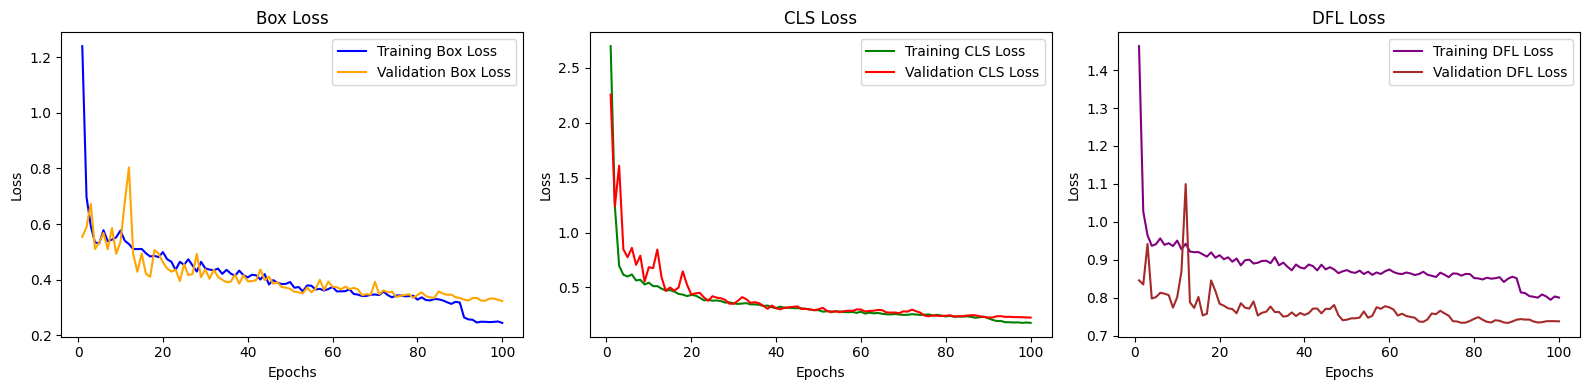

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# Line chart for Training Box Loss and Validation Box Loss
ax1.plot(epochs, train_box_loss, label='Training Box Loss', color='blue')
ax1.plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Box Loss')

# Line chart for Training CLS Loss and Validation CLS Loss
ax2.plot(epochs, train_cls_loss, label='Training CLS Loss', color='green')
ax2.plot(epochs, val_cls_loss, label='Validation CLS Loss', color='red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title('CLS Loss')

# Line chart for Training DFL Loss and Validation DFL Loss
ax3.plot(epochs, train_dfl_loss, label='Training DFL Loss', color='purple')
ax3.plot(epochs, val_dfl_loss, label='Validation DFL Loss', color='brown')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.set_title('DFL Loss')

plt.tight_layout()
plt.show()

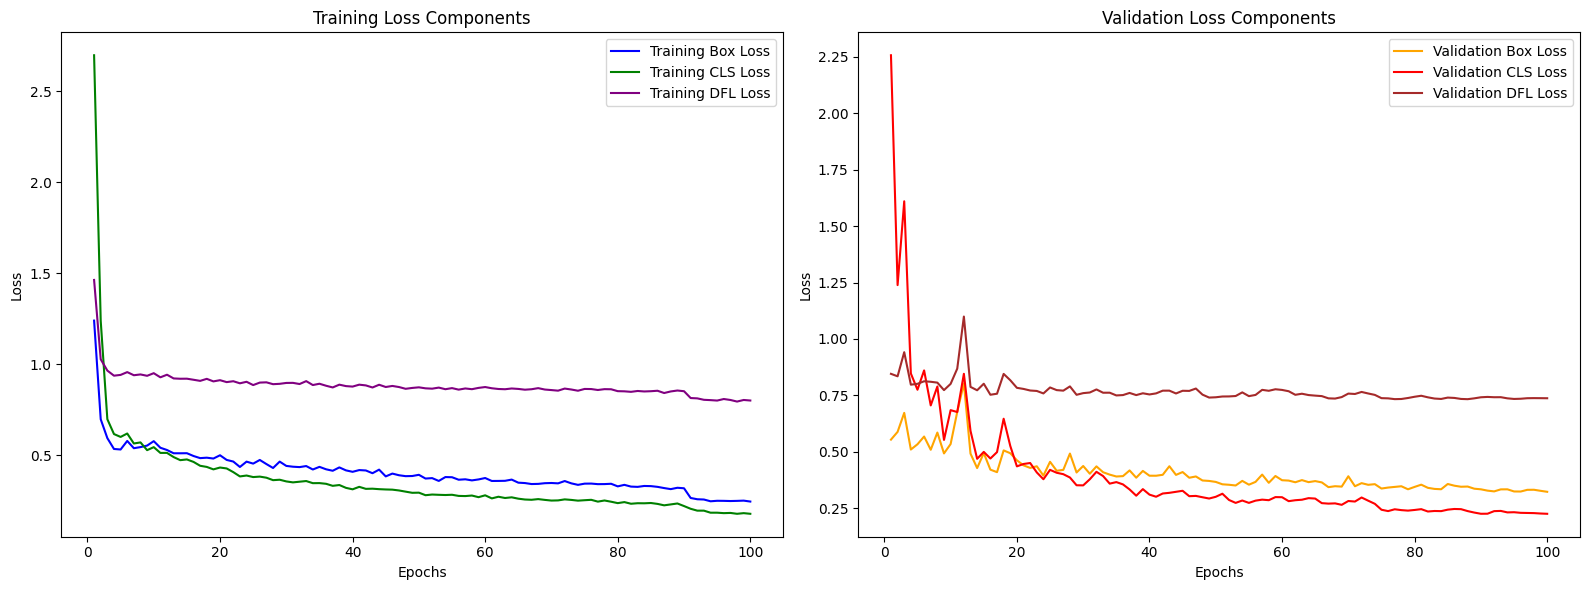

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1 - Training Data
ax1.plot(epochs, train_box_loss, label='Training Box Loss', color='blue')
ax1.plot(epochs, train_cls_loss, label='Training CLS Loss', color='green')
ax1.plot(epochs, train_dfl_loss, label='Training DFL Loss', color='purple')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training Loss Components')

# Subplot 2 - Validation Data
ax2.plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
ax2.plot(epochs, val_cls_loss, label='Validation CLS Loss', color='red')
ax2.plot(epochs, val_dfl_loss, label='Validation DFL Loss', color='brown')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title('Validation Loss Components')

plt.tight_layout()
plt.show()

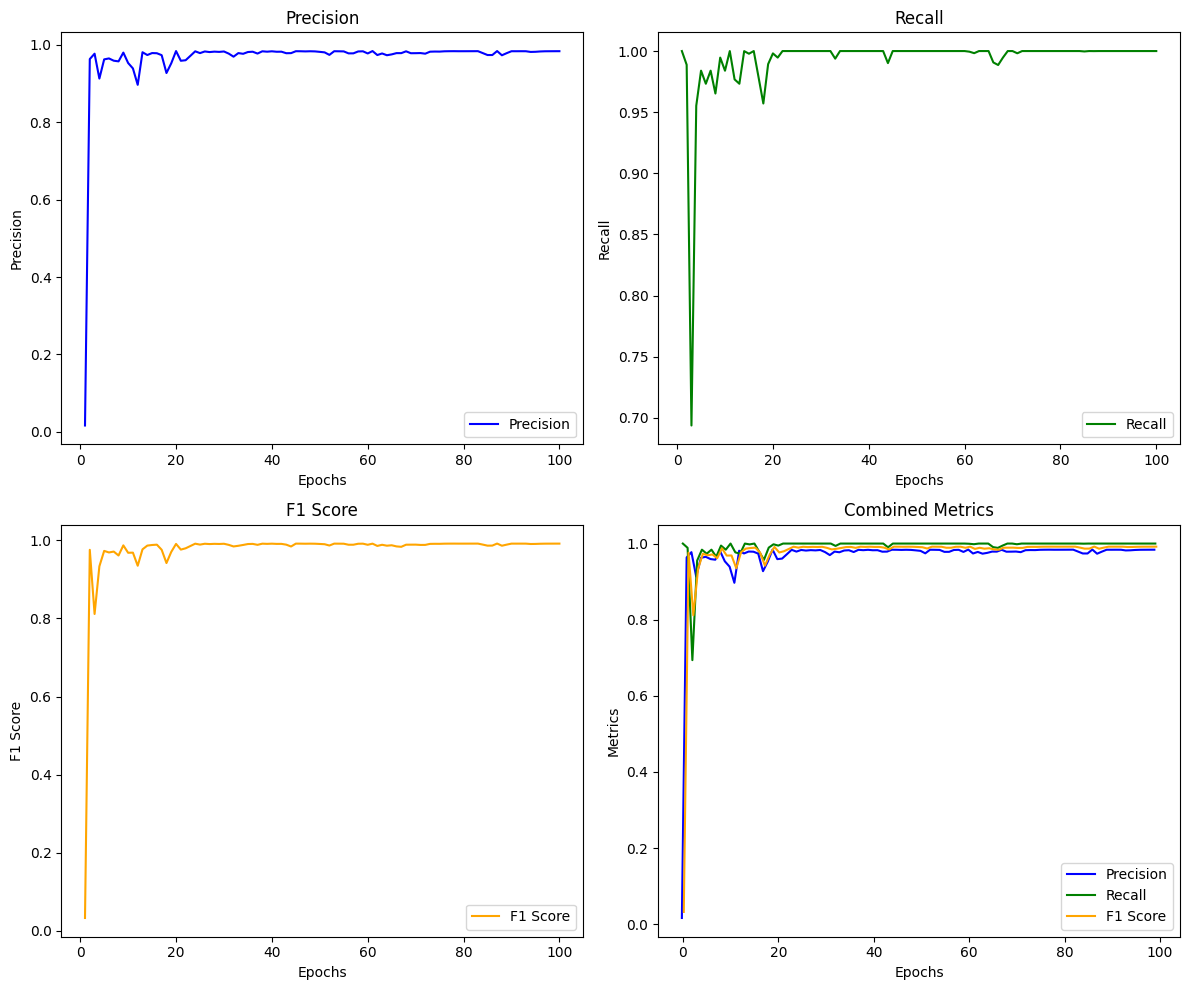

In [33]:
# Create subplots (2 rows, 2 columns) for Precision, Recall, F1 Score, and Combined
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1 - Precision
ax1.plot(epochs, class_precision, color='blue', label='Precision')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Precision')
ax1.set_title('Precision')
ax1.legend()

# Subplot 2 - Recall
ax2.plot(epochs, class_recall, color='green', label='Recall')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Recall')
ax2.set_title('Recall')
ax2.legend()

# Subplot 3 - F1 Score
ax3.plot(epochs, class_f1, color='orange', label='F1 Score')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score')
ax3.legend()

# Subplot 4 - Combined
width = 0.2
x = np.arange(len(epochs))
ax4.plot(x - width, class_precision, color='blue')
ax4.plot(x, class_recall, color='green')
ax4.plot(x + width, class_f1, color='orange')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Metrics')
ax4.set_title('Combined Metrics')
ax4.legend(['Precision', 'Recall', 'F1 Score'])

plt.tight_layout()
plt.show()

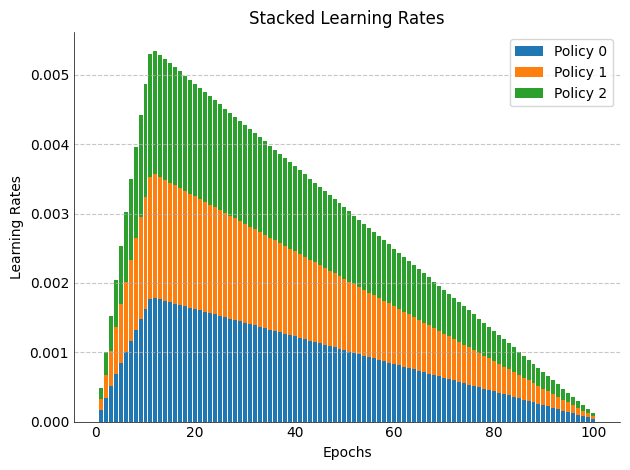

In [34]:
# Define custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot stacked bars with custom colors
ax.bar(epochs, lr_pg0, label='Policy 0', color=colors[0])
ax.bar(epochs, lr_pg1, label='Policy 1', color=colors[1], bottom=lr_pg0)
ax.bar(epochs, lr_pg2, label='Policy 2', color=colors[2], bottom=[lr_pg0[i] + lr_pg1[i] for i in range(len(epochs))])

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rates')
ax.set_title('Stacked Learning Rates')
ax.legend()

# Customize the appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='both', which='both', length=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

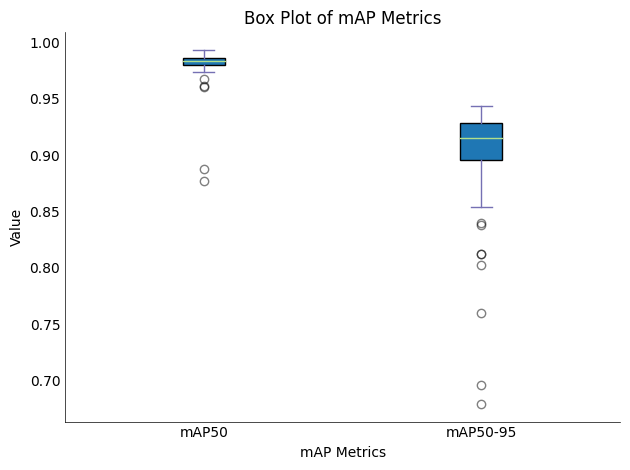

In [35]:
# Custom colors for all elements
box_color = '#1f77b4'
whisker_color = '#7570b3'
cap_color = '#7570b3'
median_color = '#b2df8a'
flier_color = '#e7298a'

# Create a figure and axis
fig, ax = plt.subplots()

# Plot box plot with custom colors
bp = ax.boxplot([mAP_50, mAP_50_95], patch_artist=True, labels=['mAP50', 'mAP50-95'])

# Set box color
for box in bp['boxes']:
    box.set(facecolor=box_color, edgecolor='black')

# Set whisker color
for whisker in bp['whiskers']:
    whisker.set(color=whisker_color)

# Set cap color
for cap in bp['caps']:
    cap.set(color=cap_color)

# Set median line color
for median in bp['medians']:
    median.set(color=median_color)

# Set flier color
for flier in bp['fliers']:
    flier.set(marker='o', color=flier_color, alpha=0.5)

# Set labels and title
ax.set_xlabel('mAP Metrics')
ax.set_ylabel('Value')
ax.set_title('Box Plot of mAP Metrics')

# Customize the appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='both', which='both', length=0)

# Show the plot
plt.tight_layout()
plt.show()

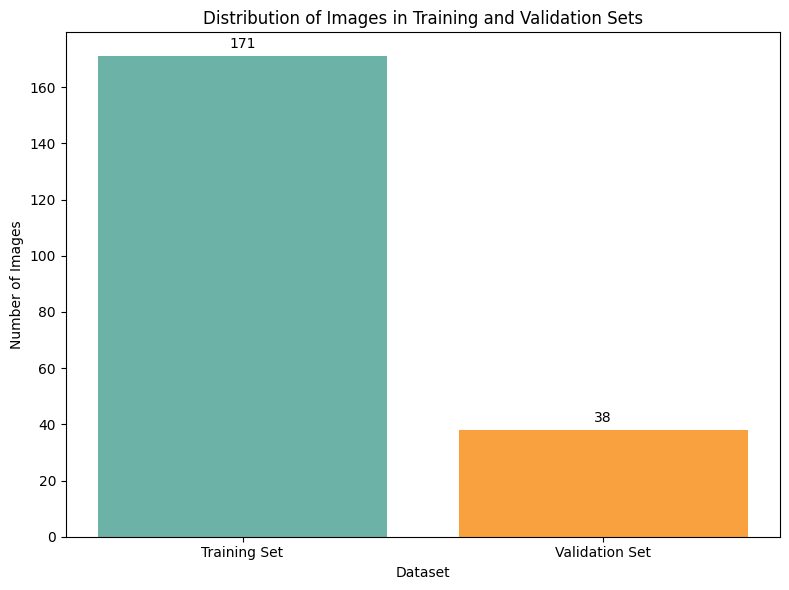

In [36]:
# Number of images in the training and validation sets
train_images = 171
val_images = 38
total_images = train_images + val_images

# Labels for the bars
labels = ['Training Set', 'Validation Set']

# Number of images for each set
image_counts = [train_images, val_images]

# Define custom colors for the bars
colors = ['#6CB2A7', '#F9A03F']  # You can adjust these color codes

# Create a bar plot with adjusted margins
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, image_counts, color=colors)
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Training and Validation Sets')

# Display the image counts on the bars with adjusted margins
for bar, count in zip(bars, image_counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3, str(count), ha='center')

plt.tight_layout()
plt.show()